# Detección de fraude en transacciones con tarjeta utilizando Amazon Fraud Detector

[Amazon Fraud Detector](https://docs.aws.amazon.com/frauddetector/latest/ug/what-is-frauddetector.html) es un servicio completamente administrado que utiliza aprendizaje automático (ML) y 20 años de experiencia de Amazon en detección de fraudes para identificar actividades potencialmente fraudulentas en línea.

Amazon Fraud Detector automatiza las tareas arduas y costosas que conlleva crear, entrenar e implementar un modelo de aprendizaje automático para detectar fraudes, de modo que hace que sea más fácil para los clientes sacar provecho de la tecnología. Amazon Fraud Detector personaliza cada modelo que crea de acuerdo con el propio conjunto de datos de un cliente, de forma que los modelos son más precisos que las soluciones universales de aprendizaje automático actuales.

Algunas aplicaciones para esto son

* Pago en línea: Con Amazon Fraud Detector, se puede configurar el flujo del servicio de compras a fin de evaluar nuevos pedidos, detectar los sospechosos y revisarlos antes de procesar los pagos.
* Nuevas cuentas: Por ejemplo, se puede configurar el flujo de trabajo de registro de la cuenta del cliente para que solicite pasos adicionales de verificación del email y el número de teléfono únicamente en el caso de registros de cuentas que presenten características de alto riesgo.
* Usuarios sin récord: Detectar a posibles estafadores entre clientes sin historial de transacciones. Con Amazon Fraud Detector, solo se debe enviar dos elementos de datos de un pedido de compra de un usuario sin registrar (como el email y la dirección IP) para evaluar el posible riesgo de fraude, y así poder decidir si se acepta, se revisa o si se recopilan más detalles sobre el cliente.


En este Notebook haremos un entrenamiento de Amazon Fraud Detector utilizando un dataset de transacciones online. El dataset está disponible públicamente en este [enlace](https://www.kaggle.com/datasets/kartik2112/fraud-detection). Dado su peso, se debe precargar ambos archivos en un bucket de S3 previamente.

## Preparación del dataset

Para poder utilizar Fraud Detector, el dataset debe cumplir con diversas características, documentadas en este [enlace](https://docs.aws.amazon.com/frauddetector/latest/ug/create-event-dataset.html). Si no va a utilizarse el dataset indicado en el texto anterior, se debe verificar primero cumplir con lo siguiente:

* Por lo menos 10K registros
* Por lo menos 400 eventos de fraude en los registros
* Por lo menos 400 eventos de transacción legítima
* Por lo menos 100 entidades únicas en los registros

In [320]:
# importando librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import dateutil.parser
import glob
import os
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score

In [2]:
import boto3
import sagemaker
s3 = boto3.client("s3", region_name='us-east-1')
fraud_detector = boto3.client('frauddetector', region_name='us-east-1')
role = sagemaker.get_execution_role()

In [3]:
# Definición de variables
EVENT_TYPE     = "credit_card_transaction"
EVENT_DESC     = "credit card transaction"

MODEL_NAME     = "credit_card_transaction_fraud_detection_model"
MODEL_DESC     = "credit card transaction fraud detection"

DETECTOR_NAME  = "credit_card_transaction_fraud_detection_detector"                       
DETECTOR_DESC  = "your detector description"

MODEL_TYPE     = "TRANSACTION_FRAUD_INSIGHTS" # Opciones: TRANSACTION_FRAUD_INSIGHTS, ONLINE_FRAUD_INSIGHTS

S3_BUCKET      = "fraud-detector-credit-card-transaction-10172022"              
S3_FILE        = "dataset/fraudTrain.csv"
S3_FILE_TEST   = "dataset/fraudTest.csv"
ARN_ROLE       = role


VARIABLES_MAP = {
    "CARD_BIN": "cc_num_6",
    "PRODUCT_CATEGORY": "category",
    "SHIPPING_CITY": "city",
    "SHIPPING_STATE": "state",
    "SHIPPING_ZIP": "zip",
    "CATEGORICAL": "gender",
    "PRICE": "amt",
    "CATEGORICAL": "job"
}

In [5]:
obj  = s3.get_object(Bucket=S3_BUCKET, Key=S3_FILE)
body = obj['Body']
df = pd.read_csv(body)

In [142]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [143]:
df.tail()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1296670,1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0
1296674,1296674,2020-06-21 12:13:37,4292902571056973207,"fraud_Langosh, Wintheiser and Hyatt",food_dining,4.30,Jeffrey,Smith,M,135 Joseph Mountains,...,45.8433,-113.8748,218,"Therapist, horticultural",1995-08-16,8f7c8e4ab7f25875d753b422917c98c9,1371816817,46.565983,-114.186110,0


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [144]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

In [145]:
df = df.sort_values(by='trans_date_trans_time')

In [146]:
# La data para fraud detector no puede ser mas antigua que 18 meses, asi que modificaremos las fechas para este ejercicio
df['trans_date_trans_time'] = df['trans_date_trans_time'] + pd.offsets.DateOffset(years=2)

In [147]:
df.tail()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
1296670,1296670,2022-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,...,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,1296671,2022-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,...,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,1296672,2022-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,...,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,1296673,2022-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0
1296674,1296674,2022-06-21 12:13:37,4292902571056973207,"fraud_Langosh, Wintheiser and Hyatt",food_dining,4.30,Jeffrey,Smith,M,135 Joseph Mountains,...,45.8433,-113.8748,218,"Therapist, horticultural",1995-08-16,8f7c8e4ab7f25875d753b422917c98c9,1371816817,46.565983,-114.186110,0


In [148]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2021-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2021-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2021-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2021-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2021-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [149]:
split_date = datetime.datetime(2021,4,30,23,59,59)

In [150]:
df = df.loc[df['trans_date_trans_time'] > split_date]

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1055267 entries, 241408 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Unnamed: 0             1055267 non-null  int64         
 1   trans_date_trans_time  1055267 non-null  datetime64[ns]
 2   cc_num                 1055267 non-null  int64         
 3   merchant               1055267 non-null  object        
 4   category               1055267 non-null  object        
 5   amt                    1055267 non-null  float64       
 6   first                  1055267 non-null  object        
 7   last                   1055267 non-null  object        
 8   gender                 1055267 non-null  object        
 9   street                 1055267 non-null  object        
 10  city                   1055267 non-null  object        
 11  state                  1055267 non-null  object        
 12  zip                    

In [152]:
df = df.rename(columns = { 'merchant': 'ENTITY_ID', 'trans_num': 'EVENT_ID', 'trans_date_trans_time': 'EVENT_TIMESTAMP' , 'is_fraud': 'EVENT_LABEL'})

In [153]:
df['cc_num'] = df['cc_num'].astype(str).str[:6]

In [154]:
df = df.drop(columns = ['first', 'last', 'city_pop', 'unix_time', 'long','street','merch_long','merch_lat','lat', 'Unnamed: 0'])

In [155]:
df['dob'] = pd.to_datetime(df['dob'], format='%Y-%m-%d')

In [156]:
df['age'] = (df['EVENT_TIMESTAMP']-df['dob']).astype('timedelta64[Y]').astype('int')

In [157]:
df = df.drop( columns = ['dob'])

In [158]:
df['ENTITY_TYPE'] = 'merchant'

In [159]:
# Formato de fecha para fraud detector
df["EVENT_TIMESTAMP"] = df["EVENT_TIMESTAMP"].dt.strftime('%Y-%m-%dT%H:%M:%SZ')

In [160]:
df['LABEL_TIMESTAMP'] = df['EVENT_TIMESTAMP']

In [161]:
df[['zip', 'age', 'amt', 'EVENT_LABEL']] = df[['zip', 'age', 'amt', 'EVENT_LABEL']].astype(str)

In [162]:
df['ENTITY_ID'] = df['ENTITY_ID'].str.replace(r'[\', ]', '', regex=True)

In [163]:
df['job'] = df['job'].str.replace(r'[\'/, ]', '_', regex=True)

In [164]:
df.head()

,EVENT_TIMESTAMP,cc_num,ENTITY_ID,category,amt,gender,city,state,zip,job,EVENT_ID,EVENT_LABEL,age,ENTITY_TYPE,LABEL_TIMESTAMP
241408,2021-05-01T00:00:01Z,180094,fraud_MosciskiGislasonandMertz,grocery_pos,181.17,F,Sun City,CA,92585,Designer__exhibition_display,443cbb2429029854090661d50bbbc065,0,48,merchant,2021-05-01T00:00:01Z
241409,2021-05-01T00:01:18Z,356196,fraud_Bruen-Yost,misc_pos,40.0,M,Shelter Island,NY,11964,Clinical_biochemist,f1d8793a96ea170f7ceb5f24aa1bb206,0,37,merchant,2021-05-01T00:01:18Z
241410,2021-05-01T00:02:06Z,470899,fraud_HuelHammesandWitting,grocery_pos,118.83,M,Cord,AR,72524,Designer__ceramics_pottery,b0dbb78aa17249dae8d8ec5f0dc24dd4,0,82,merchant,2021-05-01T00:02:06Z
241411,2021-05-01T00:02:36Z,502012,fraud_McGlynn-Heathcote,misc_net,8.59,F,Garrattsville,NY,13342,Naval_architect,c45fe601cdcb9bd6ef2c074cba89bd5d,0,75,merchant,2021-05-01T00:02:36Z
241412,2021-05-01T00:02:40Z,345060,fraud_MosciskiGislasonandMertz,grocery_pos,115.52,M,Ashfield,MA,1330,Production_assistant__radio,83f2c4597dfd054c30027e534da354be,0,61,merchant,2021-05-01T00:02:40Z


In [165]:
df.describe()

,EVENT_TIMESTAMP,cc_num,ENTITY_ID,category,amt,gender,city,state,zip,job,EVENT_ID,EVENT_LABEL,age,ENTITY_TYPE,LABEL_TIMESTAMP
count,1055267,1055267,1055267,1055267,1055267,1055267,1055267,1055267,1055267,1055267,1055267,1055267,1055267,1055267,1055267
unique,1036682,934,693,14,48548,2,873,50,944,490,1055267,2,82,1,1036682
top,2022-06-01T01:37:47Z,601136,fraud_KilbackLLC,gas_transport,1.02,F,Birmingham,TX,73754,Film_video_editor,443cbb2429029854090661d50bbbc065,0,49,merchant,2022-06-01T01:37:47Z
freq,4,5025,3583,107179,444,577823,4587,77228,3012,8021,1,1049654,34282,1055267,4


## Creando las variables en Fraud Detector

Escribimos un mapa entre las variables y su tipo (esto no incluye los valores requeridos por Fraud Detector)

In [260]:
VARIABLE_MAP = {
    "cc_num": { 'variableType': "CARD_BIN", 'dataType': 'STRING', 'defaultValue': '<null>'},
    "category": { 'variableType': "PRODUCT_CATEGORY", 'dataType': 'STRING', 'defaultValue': '<null>'},
    "city": { 'variableType': "SHIPPING_CITY", 'dataType': 'STRING', 'defaultValue': '<null>' },
    "state": { 'variableType': "SHIPPING_STATE", 'dataType': 'STRING', 'defaultValue': '<null>'},
    "zip": { 'variableType': "SHIPPING_ZIP", 'dataType': 'STRING', 'defaultValue': '<null>' },
    "amt": { 'variableType': "PRICE", 'dataType': 'FLOAT', 'defaultValue': '70.0'},
    "job": { 'variableType': "CATEGORICAL", 'dataType': 'STRING', 'defaultValue': '<null>'},
    "gender": { 'variableType': "CATEGORICAL", 'dataType': 'STRING', 'defaultValue': '<null>'},
    "age": { 'variableType': "NUMERIC", 'dataType': 'FLOAT', 'defaultValue': '45'}
}

In [33]:
for variable_name in VARIABLE_MAP.keys():
    fraud_detector.create_variable(
        name = variable_name,
        dataType = VARIABLE_MAP[variable_name]['dataType'],
        dataSource = 'EVENT',
        defaultValue = VARIABLE_MAP[variable_name]['defaultValue'],
        variableType = VARIABLE_MAP[variable_name]['variableType'],
        tags = [
            {
                'key': 'project',
                'value': 'sample_notebook'
            }
        ]
    )

## Creando las lables en Fraud Detector

Las labels indican si una transacción fue fraudulenta o no. En este dataset, un valor de 1 indica que la transacción fue fraudulenta y un 0 indica que fue legítima

In [38]:
fraud_detector.put_label(
    name = '1',
    description = 'FRAUD'
)

{'ResponseMetadata': {'RequestId': '6cad451a-d979-41f0-a334-b53aa9268555',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 20 Oct 2022 22:15:23 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '6cad451a-d979-41f0-a334-b53aa9268555'},
  'RetryAttempts': 0}}

In [39]:
fraud_detector.put_label(
    name = '0',
    description = 'LEGIT'
)

{'ResponseMetadata': {'RequestId': '5fdc8dfd-943b-4e94-bc80-b9584fd08e33',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 20 Oct 2022 22:15:27 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '5fdc8dfd-943b-4e94-bc80-b9584fd08e33'},
  'RetryAttempts': 0}}

## Creando el entity_type en Fraud Detector

Una entidad representa a quién está generando el evento. Un entity type clasifica a la entidad. Ejemplos de clasificaciones incluyen cliente, cuenta o comerciante 

In [36]:
entity_type = list(df['ENTITY_TYPE'].unique())[0]

In [45]:
fraud_detector.put_entity_type(
    name = entity_type,
    description = 'Merchant in sample_notebook'
)

{'ResponseMetadata': {'RequestId': 'f7d4cbdf-d7bc-4b6f-b950-3d36ab9b082e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 20 Oct 2022 22:29:46 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'f7d4cbdf-d7bc-4b6f-b950-3d36ab9b082e'},
  'RetryAttempts': 0}}

## Creando el event_type en Fraud Detector

Un evento es una actividad que es evaluada para riesgo de fraude. Ejemplos de event types incluyen pago de transacciones en línea, registro de cuentas y autenticaciones.

In [47]:
fraud_detector.put_event_type(
    name= EVENT_TYPE,
    description= 'Event type for sample_notebook',
    eventVariables= list(VARIABLE_MAP.keys()),
    labels=[
        '1',
        '0'
    ],
    entityTypes=[
        entity_type,
    ],
    eventIngestion='ENABLED',
    tags=[
        {
            'key': 'project',
            'value': 'sample_notebook'
        }
    ]
)

{'ResponseMetadata': {'RequestId': 'bb949ee1-2821-45ee-b202-967b52decc77',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 20 Oct 2022 22:34:23 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'bb949ee1-2821-45ee-b202-967b52decc77'},
  'RetryAttempts': 0}}

## Creando in import job para los eventos

In [166]:
# Subimos los datos a S3
df.to_csv('train_events.csv', index=False)

In [167]:
s3.upload_file(Filename="train_events.csv", Bucket=S3_BUCKET, Key="train/train_events.csv")

In [168]:
fraud_detector.create_batch_import_job(
    jobId = f'batch_import_{EVENT_TYPE}',
    inputPath = f's3://{S3_BUCKET}/train/train_events.csv',
    outputPath = f's3://{S3_BUCKET}/output/',
    eventTypeName = EVENT_TYPE,
    iamRoleArn = ARN_ROLE
)

{'ResponseMetadata': {'RequestId': '8d3ebc87-6de1-455a-8a1e-a6211e25d50f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 24 Oct 2022 07:10:21 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '8d3ebc87-6de1-455a-8a1e-a6211e25d50f'},
  'RetryAttempts': 0}}

El import job toma un tiempo en completarse, podemos revisar el status ejecutando la siguiente celda

In [186]:
response = fraud_detector.get_batch_import_jobs(jobId = f'batch_import_{EVENT_TYPE}')
status = response['batchImports'][0]['status']
status

'COMPLETE'

## Crear el modelo

In [188]:
response = fraud_detector.create_model(
   description   = MODEL_DESC,
   eventTypeName = EVENT_TYPE,
   modelId       = MODEL_NAME,
   modelType     = MODEL_TYPE)
response

{'ResponseMetadata': {'RequestId': '8d91a9e2-9d0b-4602-9282-d68c38231773',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 24 Oct 2022 15:18:41 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '8d91a9e2-9d0b-4602-9282-d68c38231773'},
  'RetryAttempts': 0}}

In [195]:
TRAINING_DATA_SCHEMA = {
    'modelVariables': ['cc_num', 'category', 'city', 'state', 'zip', 'age', 'gender', 'amt', 'job'],
    'labelSchema': {
        'labelMapper': {
            'FRAUD': ['1'],
            'LEGIT': ['0']
        },
        'unlabeledEventsTreatment': 'IGNORE'
    }
}

In [199]:
response = fraud_detector.create_model_version(
    modelId             = MODEL_NAME,
    modelType           = MODEL_TYPE,
    trainingDataSource  = 'INGESTED_EVENTS',
    trainingDataSchema  = TRAINING_DATA_SCHEMA,
    ingestedEventsDetail={
          'ingestedEventsTimeWindow': {
              'startTime': df['EVENT_TIMESTAMP'].min(),
              'endTime': df['EVENT_TIMESTAMP'].max()
          }
    }
)
response

{'modelId': 'credit_card_transaction_fraud_detection_model',
 'modelType': 'TRANSACTION_FRAUD_INSIGHTS',
 'modelVersionNumber': '1.0',
 'status': 'TRAINING_IN_PROGRESS',
 'ResponseMetadata': {'RequestId': 'b8a8db03-6aaa-46fa-816d-b9434d2ef8fd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 24 Oct 2022 15:31:23 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '159',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'b8a8db03-6aaa-46fa-816d-b9434d2ef8fd'},
  'RetryAttempts': 0}}

In [200]:
MODEL_VERSION = response['modelVersionNumber']

El modelo tomará aproximadamente 1 hora en entrenarse. Podemos revisar el status del entrenamiento con la siguiente celda

In [204]:
response = fraud_detector.get_model_version(
    modelId = MODEL_NAME, 
    modelType = MODEL_TYPE, 
    modelVersionNumber = MODEL_VERSION
)
response['status']

'TRAINING_COMPLETE'

In [224]:
# Cambiar el status del modelo a activo
response = fraud_detector.update_model_version_status (
    modelId            = MODEL_NAME,
    modelType          = MODEL_TYPE,
    modelVersionNumber = MODEL_VERSION,
    status             = 'ACTIVE'
)
response

{'ResponseMetadata': {'RequestId': 'b70fa4bf-2077-4870-8f99-f16e934cbfbd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 25 Oct 2022 00:00:56 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'b70fa4bf-2077-4870-8f99-f16e934cbfbd'},
  'RetryAttempts': 0}}

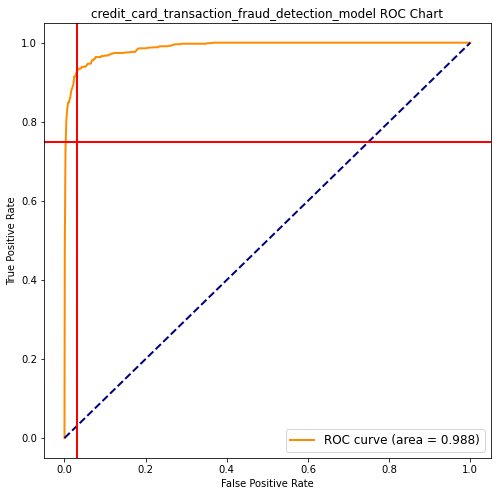

In [206]:
trainingMetrics = fraud_detector.describe_model_versions(
    modelId            = MODEL_NAME,
    modelVersionNumber = MODEL_VERSION,
    modelType          = MODEL_TYPE,
    maxResults         = 10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']

perf_auc = trainingMetrics['auc']
df_model = pd.DataFrame(trainingMetrics['metricDataPoints'])

# ROC
plt.figure(figsize = (8,8))
plt.plot(df_model["fpr"], df_model["tpr"], color='darkorange', lw=2, label='ROC curve (area = %0.3f)'%perf_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(MODEL_NAME+' ROC Chart')
plt.legend(loc="lower right", fontsize=12)
plt.axvline(x=0.03, linewidth=2, color='r')
plt.axhline(y=0.75, linewidth=2, color='r')
plt.show()

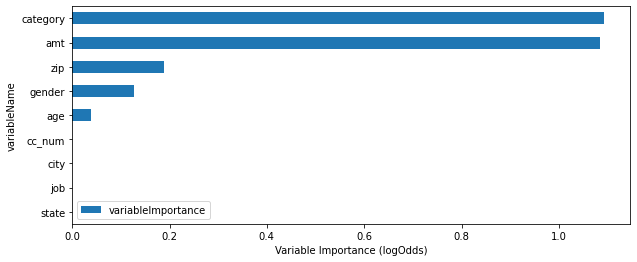

In [207]:
varImpMetrics = fraud_detector.describe_model_versions(
    modelId            = MODEL_NAME,
    modelVersionNumber = MODEL_VERSION,
    modelType          = MODEL_TYPE,
    maxResults         = 10
)['modelVersionDetails'][0]['trainingResult']['variableImportanceMetrics']

df_var_imp = pd.DataFrame(varImpMetrics['logOddsMetrics']).sort_values(by='variableImportance')

# Variables
df_var_imp.plot.barh(x='variableName',y='variableImportance',figsize=(10,int(0.5*df_var_imp.shape[0])))
plt.xlabel('Variable Importance (logOdds)')
plt.show()


## Crear un fraud detector, reglas y un detector

In [208]:
response = fraud_detector.put_detector(
    detectorId    = DETECTOR_NAME, 
    description   = DETECTOR_DESC,
    eventTypeName = EVENT_TYPE 
)

In [209]:
response

{'ResponseMetadata': {'RequestId': 'fb4b6ec9-95d5-49e2-8635-07555a11102e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 24 Oct 2022 23:36:24 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'fb4b6ec9-95d5-49e2-8635-07555a11102e'},
  'RetryAttempts': 0}}

In [211]:
model_stat = df_model.sort_values(by='fpr')
model_stat['fpr_bin']=np.ceil(model_stat['fpr']*100)*0.01
m = model_stat.loc[model_stat.groupby(["fpr_bin"])["threshold"].idxmin()] 
m = m.round(decimals=2)[['fpr','precision','tpr','threshold']]
print (" --- score thresholds 1% to 10% --- ")
print(m.loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.10)].reset_index(drop=True))

 --- score thresholds 1% to 10% --- 
    fpr  precision   tpr  threshold
0  0.01       0.34  0.85      950.0
1  0.02       0.21  0.89      905.0
2  0.03       0.15  0.92      865.0
3  0.04       0.13  0.93      825.0
4  0.05       0.10  0.94      785.0
5  0.06       0.09  0.95      750.0
6  0.07       0.07  0.96      710.0
7  0.08       0.07  0.96      680.0
8  0.09       0.06  0.96      640.0
9  0.10       0.06  0.97      610.0


In [212]:
# puntaje > 850: fraud
# puntaje > 700: investigate 
# puntaje <= 700: approve

score_cuts = [850,700]                          
outcomes = ['fraud', 'investigate', 'approve']  

In [213]:
for outcome in outcomes:
    print("creating outcome variable: {0} ".format(outcome))
    response = fraud_detector.put_outcome(name = outcome, description = outcome)

creating outcome variable: fraud 
creating outcome variable: investigate 
creating outcome variable: approve 


In [221]:
rule_list = []
rules = []
for i in range(len(outcomes)):
    
    rule = ''
    
    if i < (len(outcomes)-1):
        rule = "${0}_insightscore > {1}".format(MODEL_NAME,score_cuts[i])
    else:
        rule = "${0}_insightscore <= {1}".format(MODEL_NAME,score_cuts[i-1])

    rule_id = "rules{0}_{1}".format(i, MODEL_NAME)
    
    rules.append(rule)

    rule_list.append({
        "ruleId": rule_id, 
        "ruleVersion" : '1',
        "detectorId"  : DETECTOR_NAME
    })

In [217]:
rule_list

[{'ruleId': 'rules0_credit_card_transaction_fraud_detection_model',
  'ruleVersion': '1',
  'detectorId': 'credit_card_transaction_fraud_detection_detector',
  'rule': '$credit_card_transaction_fraud_detection_model_insightscore > 850'},
 {'ruleId': 'rules1_credit_card_transaction_fraud_detection_model',
  'ruleVersion': '1',
  'detectorId': 'credit_card_transaction_fraud_detection_detector',
  'rule': '$credit_card_transaction_fraud_detection_model_insightscore > 700'},
 {'ruleId': 'rules2_credit_card_transaction_fraud_detection_model',
  'ruleVersion': '1',
  'detectorId': 'credit_card_transaction_fraud_detection_detector',
  'rule': '$credit_card_transaction_fraud_detection_model_insightscore <= 700'}]

In [218]:
for i in range(len(outcomes)):
    response = fraud_detector.create_rule(
        ruleId = rule_list[i]['ruleId'],
        detectorId = DETECTOR_NAME,
        expression = rules[i],
        language = 'DETECTORPL',
        outcomes = [outcomes[i]]
    )

In [226]:
response = fraud_detector.create_detector_version(
    detectorId    = DETECTOR_NAME,
    rules         = rule_list,
    modelVersions = [{"modelId": MODEL_NAME, 
                      "modelType": MODEL_TYPE,
                      "modelVersionNumber": MODEL_VERSION}],
    ruleExecutionMode = 'FIRST_MATCHED'
)
response

{'detectorId': 'credit_card_transaction_fraud_detection_detector',
 'detectorVersionId': '1',
 'status': 'DRAFT',
 'ResponseMetadata': {'RequestId': '2d5d5344-6e75-4cae-9983-21fa63b4b992',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 25 Oct 2022 00:15:35 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '106',
   'connection': 'keep-alive',
   'x-amzn-requestid': '2d5d5344-6e75-4cae-9983-21fa63b4b992'},
  'RetryAttempts': 0}}

In [228]:
# Activar la última versión del detector
detector_version_summaries = fraud_detector.describe_detector(detectorId=DETECTOR_NAME)['detectorVersionSummaries']
latest_detector_version = max([det['detectorVersionId'] for det in detector_version_summaries])
print('Latest Detector Version:', latest_detector_version)

Latest Detector Version: 1


In [229]:
response = fraud_detector.update_detector_version_status(
    detectorId        = DETECTOR_NAME,
    detectorVersionId = latest_detector_version,
    status            = 'ACTIVE'
)
response

{'ResponseMetadata': {'RequestId': '1488784c-59a3-4d88-adcd-f7724e518654',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 25 Oct 2022 00:17:46 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '1488784c-59a3-4d88-adcd-f7724e518654'},
  'RetryAttempts': 0}}

## Hacer predicciones

In [231]:
obj  = s3.get_object(Bucket=S3_BUCKET, Key=S3_FILE_TEST)
body = obj['Body']
df_test = pd.read_csv(body)

In [244]:
df_test['trans_date_trans_time'] = pd.to_datetime(df_test['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

In [245]:
df_test = df_test.sort_values(by='trans_date_trans_time')

In [246]:
# La data para fraud detector no puede ser mas antigua que 18 meses, asi que modificaremos las fechas para este ejercicio
df_test['trans_date_trans_time'] = df_test['trans_date_trans_time'] + pd.offsets.DateOffset(years=2)

In [247]:
df_test.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2022-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2022-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2022-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2022-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2022-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [248]:
df_test.tail()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
555714,555714,2022-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,...,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,555715,2022-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,...,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,555716,2022-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,...,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,555717,2022-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,...,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0
555718,555718,2022-12-31 23:59:34,4170689372027579,fraud_Dare-Marvin,entertainment,38.13,Samuel,Frey,M,830 Myers Plaza Apt. 384,...,35.6665,-97.4798,116001,Media buyer,1993-05-10,1765bb45b3aa3224b4cdcb6e7a96cee3,1388534374,36.210097,-97.036372,0


In [249]:
split_date = datetime.datetime(2022,10,20,23,59,59)

In [250]:
df_test = df_test.loc[df_test['trans_date_trans_time'] < split_date]

In [251]:
df_test = df_test.rename(columns = { 'merchant': 'ENTITY_ID', 'trans_num': 'EVENT_ID', 'trans_date_trans_time': 'EVENT_TIMESTAMP' , 'is_fraud': 'EVENT_LABEL'})
df_test['cc_num'] = df_test['cc_num'].astype(str).str[:6]
df_test = df_test.drop(columns = ['first', 'last', 'city_pop', 'unix_time', 'long','street','merch_long','merch_lat','lat', 'Unnamed: 0'])
df_test['dob'] = pd.to_datetime(df_test['dob'], format='%Y-%m-%d')
df_test['age'] = (df_test['EVENT_TIMESTAMP']-df_test['dob']).astype('timedelta64[Y]').astype('int')
df_test = df_test.drop( columns = ['dob'])
df_test['ENTITY_TYPE'] = 'merchant'

# Formato de fecha para fraud detector
df_test["EVENT_TIMESTAMP"] = df_test["EVENT_TIMESTAMP"].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
df_test['LABEL_TIMESTAMP'] = df_test['EVENT_TIMESTAMP']
df_test[['zip', 'age', 'amt', 'EVENT_LABEL']] = df_test[['zip', 'age', 'amt', 'EVENT_LABEL']].astype(str)
df_test['ENTITY_ID'] = df_test['ENTITY_ID'].str.replace(r'[\', ]', '', regex=True)
df_test['job'] = df_test['job'].str.replace(r'[\'/, ]', '_', regex=True)

In [252]:
df_test.head()

,EVENT_TIMESTAMP,cc_num,ENTITY_ID,category,amt,gender,city,state,zip,job,EVENT_ID,EVENT_LABEL,age,ENTITY_TYPE,LABEL_TIMESTAMP
0,2022-06-21T12:14:25Z,229116,fraud_KirlinandSons,personal_care,2.86,M,Columbia,SC,29209,Mechanical_engineer,2da90c7d74bd46a0caf3777415b3ebd3,0,54,merchant,2022-06-21T12:14:25Z
1,2022-06-21T12:14:33Z,357303,fraud_Sporer-Keebler,personal_care,29.84,F,Altonah,UT,84002,Sales_professional__IT,324cc204407e99f51b0d6ca0055005e7,0,32,merchant,2022-06-21T12:14:33Z
2,2022-06-21T12:14:53Z,359821,fraud_SwaniawskiNitzscheandWelch,health_fitness,41.28,F,Bellmore,NY,11710,Librarian__public,c81755dbbbea9d5c77f094348a7579be,0,51,merchant,2022-06-21T12:14:53Z
3,2022-06-21T12:15:15Z,359191,fraud_HaleyGroup,misc_pos,60.05,M,Titusville,FL,32780,Set_designer,2159175b9efe66dc301f149d3d5abf8c,0,34,merchant,2022-06-21T12:15:15Z
4,2022-06-21T12:15:17Z,352682,fraud_Johnston-Casper,travel,3.19,M,Falmouth,MI,49632,Furniture_designer,57ff021bd3f328f8738bb535c302a31b,0,66,merchant,2022-06-21T12:15:17Z


In [255]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320647 entries, 0 to 320646
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   EVENT_TIMESTAMP  320647 non-null  object
 1   cc_num           320647 non-null  object
 2   ENTITY_ID        320647 non-null  object
 3   category         320647 non-null  object
 4   amt              320647 non-null  object
 5   gender           320647 non-null  object
 6   city             320647 non-null  object
 7   state            320647 non-null  object
 8   zip              320647 non-null  object
 9   job              320647 non-null  object
 10  EVENT_ID         320647 non-null  object
 11  EVENT_LABEL      320647 non-null  object
 12  age              320647 non-null  object
 13  ENTITY_TYPE      320647 non-null  object
 14  LABEL_TIMESTAMP  320647 non-null  object
dtypes: object(15)
memory usage: 39.1+ MB


In [269]:
sample_test = df_test.iloc[0].copy()

In [254]:
sample_test

EVENT_TIMESTAMP                2022-06-21T12:14:25Z
cc_num                                       229116
ENTITY_ID                       fraud_KirlinandSons
category                              personal_care
amt                                            2.86
gender                                            M
city                                       Columbia
state                                            SC
zip                                           29209
job                             Mechanical_engineer
EVENT_ID           2da90c7d74bd46a0caf3777415b3ebd3
EVENT_LABEL                                       0
age                                              54
ENTITY_TYPE                                merchant
LABEL_TIMESTAMP                2022-06-21T12:14:25Z
Name: 0, dtype: object

In [282]:
def _predict(record):

    event_id = record['EVENT_ID']
    entity_id = record['ENTITY_ID']
    event_timestamp = record['EVENT_TIMESTAMP']
    label_timestamp = record['LABEL_TIMESTAMP']
    
    rec_content = {}
    for variable_name in VARIABLE_MAP.keys():
        rec_content[variable_name] = record[variable_name]

    try:
        pred = fraud_detector.get_event_prediction(
            detectorId        = DETECTOR_NAME,
            detectorVersionId = latest_detector_version,
            eventId           = event_id,
            eventTypeName     = EVENT_TYPE,
            eventTimestamp    = label_timestamp, 
            entities          = [{
                'entityType': entity_type, 
                'entityId': entity_id
            }],
            eventVariables    = rec_content
        ) 
        record['score'] = pred['modelScores'][0]['scores']["{0}_insightscore".format(MODEL_NAME)]
        record['outcome'] = pred['ruleResults'][0]['outcomes']
    except:
        record['score'] = "-999"
        record['outcome'] = "error"
    
    return record


In [283]:
record = _predict(sample_test)

In [276]:
record

EVENT_TIMESTAMP                2022-06-21T12:14:25Z
cc_num                                       229116
ENTITY_ID                       fraud_KirlinandSons
category                              personal_care
amt                                            2.86
gender                                            M
city                                       Columbia
state                                            SC
zip                                           29209
job                             Mechanical_engineer
EVENT_ID           2da90c7d74bd46a0caf3777415b3ebd3
EVENT_LABEL                                       0
age                                              54
ENTITY_TYPE                                merchant
LABEL_TIMESTAMP                2022-06-21T12:14:25Z
score                                         113.0
outcome                                   [approve]
Name: 0, dtype: object

In [312]:
test = df_test.head(50).copy()
test = test.append(df_test[df_test['EVENT_LABEL'] == '1'].head(50).copy())

In [314]:
predictions = []
for i in range(len(test)):
    prediction = _predict(test.iloc[i])
    predictions.append(prediction)

In [315]:
df_pred = pd.DataFrame(predictions)

In [316]:
df_pred.head()

,EVENT_TIMESTAMP,cc_num,ENTITY_ID,category,amt,gender,city,state,zip,job,EVENT_ID,EVENT_LABEL,age,ENTITY_TYPE,LABEL_TIMESTAMP,score,outcome
0,2022-06-21T12:14:25Z,229116,fraud_KirlinandSons,personal_care,2.86,M,Columbia,SC,29209,Mechanical_engineer,2da90c7d74bd46a0caf3777415b3ebd3,0,54,merchant,2022-06-21T12:14:25Z,113.0,[approve]
1,2022-06-21T12:14:33Z,357303,fraud_Sporer-Keebler,personal_care,29.84,F,Altonah,UT,84002,Sales_professional__IT,324cc204407e99f51b0d6ca0055005e7,0,32,merchant,2022-06-21T12:14:33Z,535.0,[approve]
2,2022-06-21T12:14:53Z,359821,fraud_SwaniawskiNitzscheandWelch,health_fitness,41.28,F,Bellmore,NY,11710,Librarian__public,c81755dbbbea9d5c77f094348a7579be,0,51,merchant,2022-06-21T12:14:53Z,226.0,[approve]
3,2022-06-21T12:15:15Z,359191,fraud_HaleyGroup,misc_pos,60.05,M,Titusville,FL,32780,Set_designer,2159175b9efe66dc301f149d3d5abf8c,0,34,merchant,2022-06-21T12:15:15Z,127.0,[approve]
4,2022-06-21T12:15:17Z,352682,fraud_Johnston-Casper,travel,3.19,M,Falmouth,MI,49632,Furniture_designer,57ff021bd3f328f8738bb535c302a31b,0,66,merchant,2022-06-21T12:15:17Z,748.0,[investigate]


In [289]:
labelMapper = {
    'FRAUD': ['1'],
    'LEGIT': ['0']
}

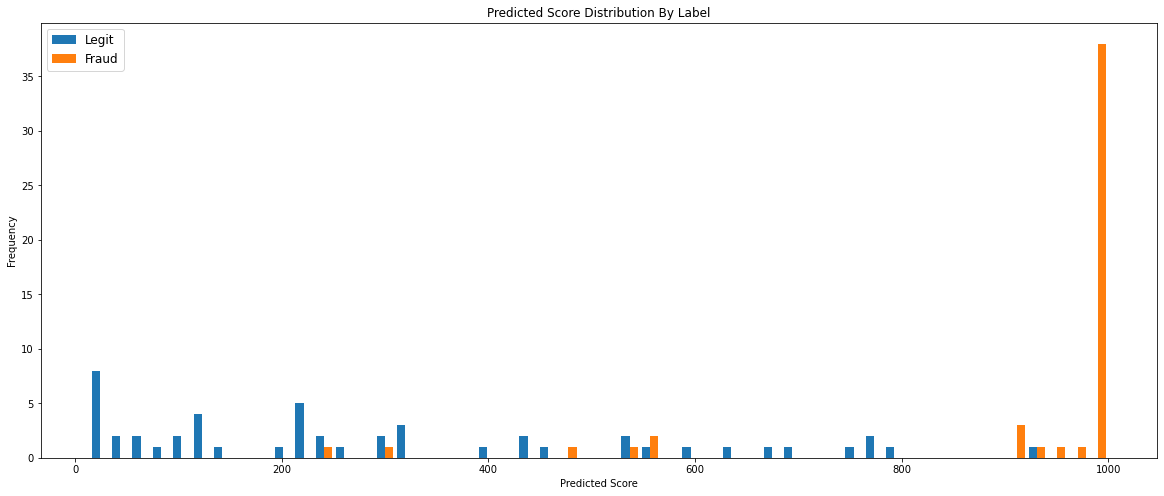

In [317]:
plt.figure(figsize = (20,8))
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
plt.hist([df_pred[df_pred['EVENT_LABEL'].isin(labelMapper['LEGIT'])]['score'], 
          df_pred[df_pred['EVENT_LABEL'].isin(labelMapper['FRAUD'])]['score']], bins = 50)
plt.legend(["Legit", "Fraud"], fontsize=12)
plt.title("Predicted Score Distribution By Label")
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.show()

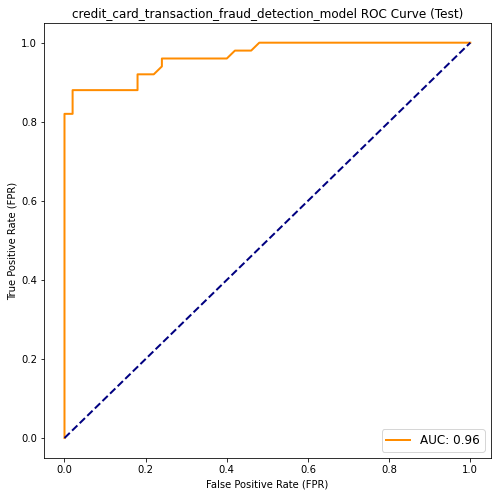

In [321]:
df_pred['event_label_int'] = np.nan
df_pred.loc[df_pred['EVENT_LABEL'].isin(labelMapper['LEGIT']), 'event_label_int'] = 0
df_pred.loc[df_pred['EVENT_LABEL'].isin(labelMapper['FRAUD']), 'event_label_int'] = 1
                
fpr, tpr, threshold = roc_curve(df_pred['event_label_int'], df_pred['score'])
test_auc = auc(fpr,tpr)

plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC: {test_auc:.2f}") 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title(MODEL_NAME+" ROC Curve (Test)")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (FPR)')
plt.legend(loc="lower right", fontsize=12)
plt.show()